# Detecting Contrails

In [5]:
# %%
from pathlib import Path

import matplotlib.pyplot as plt

from contrai.models.semantic_segmentation.coat.predict import predict


## 1. Select paths

In [6]:
from pathlib import Path

# Get current working directory
cwd = Path.cwd()

# Build paths relative to the current directory
from contrai.models.semantic_segmentation.coat.weight_loader import ensure_local_weight
model_path = ensure_local_weight("final")
image_path = cwd.parent / "notebooks/images/goes16_ash_rgb/2023/01/30/1600/ash_rgb_0p02deg.png"
output_path = Path(str(image_path).replace("/images/", "/outputs/"))

# Safety checks
assert model_path.exists(), f"Model weights not found: {model_path}"
assert image_path.exists(), f"Image not found: {image_path}"

print("Using model:", model_path)


Using model: /home/irortiza/Documents/PUBLIC_GITHUB/ContrAI/notebooks/weights/final/coat_model.pth


## 2. Run detection

In [7]:
# %%
overlay, mask, image = predict(
    model_path=model_path,
    image_path=image_path,
    tile_h=256,
    tile_w=256,
    stride=128,
    threshold=0.1,
    output=output_path,  # or None to skip saving
    show=False,          # we'll handle visualization below
    log_level="INFO",
)


2025-11-13 16:07:36,036 | INFO | Using device: cuda
2025-11-13 16:07:36,037 | INFO | Loading model from /home/irortiza/Documents/PUBLIC_GITHUB/ContrAI/notebooks/weights/final/coat_model.pth


_IncompatibleKeys(missing_keys=[], unexpected_keys=['norm1.weight', 'norm1.bias', 'norm2.weight', 'norm2.bias', 'norm3.weight', 'norm3.bias', 'norm4.weight', 'norm4.bias', 'aggregate.weight', 'aggregate.bias', 'head.weight', 'head.bias'])


2025-11-13 16:07:36,591 | INFO | Running inference: tile_h=256 tile_w=256 stride=128 threshold=0.100
2025-11-13 16:07:45,251 | INFO | Creating overlay
2025-11-13 16:07:47,758 | INFO | Saved overlay to /home/irortiza/Documents/PUBLIC_GITHUB/ContrAI/notebooks/outputs/goes16_ash_rgb/2023/01/30/1600/ash_rgb_0p02deg.png


## 3. Visualize

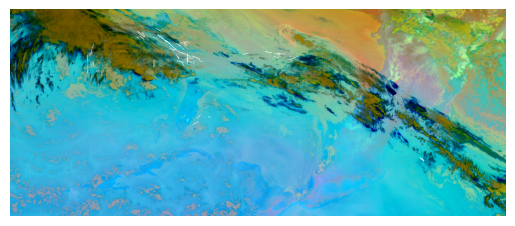

In [8]:
plt.imshow(overlay)
plt.axis('off')
plt.show()